In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import random
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Reservoir():

    """
    Parameters:
        input_size = input dimension
        hidden_size = number of internal (hidden) units in the reservoir
        sparsity = percentage of elements in W_in equal to zero
        spectral_radius = maximal absolute eigenvalue of matrix (W)*
        a = input scaling (of W_in) (how "nonlinear" reservoir responses are)*
        leak = leaking rate (speed of reservoir update dynamics over time)*
    """
    def __init__(self, input_size, hidden_size = 10000, sparsity = 0.9, 
        spectral_radius = 0.99, a = 0.6, leak = 1.0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity = sparsity
        self.spectral_radius = spectral_radius
        self.a = a
        self.leak = leak
        #self.w_in = self.gen_w_in()
        #self.w = self.gen_w()
        self.w_in = torch.load('w_in_10k.pt')
        self.w = torch.load('w_10k.pt')
        self.x = torch.zeros(self.hidden_size, 1)
  
    # [gen_w_in] generates random input weight matrix, [w_in], of size 
    # [hidden_size x input + 1], with values normally distributed around zero. 
    def gen_w_in(self):
        w_in = torch.randn(self.hidden_size, self.input_size+1).normal_(mean=0.0, std=0.6)
        torch.save(w_in, 'w_in_10k.pt') # save w_in
        return w_in

    # [gen_w] generates the internal weight matrix, [w], of size 
    # [hidden_size x hidden_size]. [w] is generated sparse with nonzero elements 
    # having a normal distribution centered around zero.
    def gen_w(self):
        w = torch.randn(self.hidden_size, self.hidden_size).normal_(mean=0.0, std=0.6)
        for i in range(w.shape[0]): 
            for j in range(w[0].shape[0]):
                if random() <= self.sparsity:
                    w[i][j] = 0
        eigenvalues = torch.eig(w)[0]
        eig_max = torch.max(eigenvalues).item()
        w *= self.spectral_radius / eig_max
        torch.save(w, 'w_10k.pt') # save w
        return w
  
    # [forward_reservoir] updates and returns the state representation [x] 
    # for given input [u]. 
    def forward_reservoir(self, u, current_x):
        temp_state = torch.tanh(torch.mm(self.w_in, 
        torch.cat((torch.tensor([[1.0]]),u),0)) + torch.mm(self.w, current_x))
        new_state = (1-self.leak) * current_x + self.leak * temp_state
        self.x = new_state
        return new_state

In [3]:
class ESN(nn.Module): 

    def __init__(self, input_size, output_size, hidden_size = 10000):
        super().__init__()
        self.reservoir = Reservoir(input_size, hidden_size)
        # self.reservoir2 = Reservoir(hidden_size, hidden_size)
        # self.reservoir3 = Reservoir(hidden_size, hidden_size)
        self.fc = nn.Linear(in_features=hidden_size, 
        out_features=output_size)  # linear layer
        # normalize resultant vector into probability distribution
        self.softmax = nn.Softmax(dim=-1)
        self.calls = 1 

    # pass in 1 x 28 x 28 image
    def forward(self, inp):
        u = inp.flatten() # flatten image into single vector
        u = u.unsqueeze(dim=0).t() # transpose to desired input shape for reservoir
        x_r = self.reservoir.forward_reservoir(u, self.reservoir.x) # pass through reservoir
        # if self.calls % len_data == (len_data-1):
        #   torch.save(x_r, 'state_x_'+str(round(self.calls/len_data))+'.pt') # save state vector
        # self.calls += 1
        # x_r = self.reservoir2.forward_reservoir(x_r, self.reservoir.x) # pass through reservoir again
        # x_r = self.reservoir3.forward_reservoir(x_r, self.reservoir.x) # pass through reservoir again
        H = self.fc(x_r.t()) # pass transposed output x through linear layer
        H_soft = self.softmax(H) # softmax
        return H_soft

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False)

In [5]:
esn = ESN(784,10) # create instance (size 784 represents flattened 28x28 image)

In [6]:
# Set parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(esn.parameters(), lr=1e-5)
len_data = len(trainset)
nsamples = 1000
nepochs = 70
loss_values = []
esn = esn.float()

In [7]:
# [train] trains the network
def train():
    start = time.time()
    for epoch in range(nepochs):
        running_loss = 0.0
        for i, data in enumerate(trainset, 0):
            if i > nsamples: 
                break
            images, labels = data

            # forward + backward + optimize
            outputs = esn(images)
            loss = criterion(outputs, torch.tensor([labels]))
    
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % nsamples == (nsamples-1):  # print every epoch
                print('epoch %d, loss: %.3f' % (epoch, running_loss/nsamples))
                
                loss_values.append(running_loss/nsamples)
              
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': esn.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': running_loss/nsamples,
                    }, '/Users/ryanhill/Desktop/Classical-RC/models/model_'+str(epoch))
      
    end = time.time()
    print("Training complete")
    print("num samples = " + str(nsamples))
    print("num epochs = " + str(nepochs))
    print("total time = " + str(end - start) + " sec")  # time in seconds
    return

In [8]:
# [test] evaluates the networks accuracy
def test():
    start = time.time()
    correct = 0
    total = 0
    for i, data in enumerate(testset, 0):
        if i > nsamples/4:
            break
        images, labels = data
        pred = torch.argmax(esn(images)).item()
        if pred == labels:
            correct += 1
        total += 1
    correct = correct*100.0 / total
    print("Testing complete")
    print("Accuracy: " + str(correct) + "%")
    end = time.time()
    print("total time = " + str(end - start) + " sec")  # time in seconds
    return

In [9]:
train()

epoch 0, loss: 2.127
epoch 1, loss: 1.887
epoch 2, loss: 1.775
epoch 3, loss: 1.722
epoch 4, loss: 1.667
epoch 5, loss: 1.636
epoch 6, loss: 1.612
epoch 7, loss: 1.593
epoch 8, loss: 1.578
epoch 9, loss: 1.565
epoch 10, loss: 1.554
epoch 11, loss: 1.544
epoch 12, loss: 1.535
epoch 13, loss: 1.528
epoch 14, loss: 1.522
epoch 15, loss: 1.517
epoch 16, loss: 1.512
epoch 17, loss: 1.508
epoch 18, loss: 1.504
epoch 19, loss: 1.500
epoch 20, loss: 1.497
epoch 21, loss: 1.494
epoch 22, loss: 1.492
epoch 23, loss: 1.490
epoch 24, loss: 1.489
epoch 25, loss: 1.487
epoch 26, loss: 1.486
epoch 27, loss: 1.485
epoch 28, loss: 1.484
epoch 29, loss: 1.483
epoch 30, loss: 1.482
epoch 31, loss: 1.481
epoch 32, loss: 1.480
epoch 33, loss: 1.479
epoch 34, loss: 1.478
epoch 35, loss: 1.478
epoch 36, loss: 1.478
epoch 37, loss: 1.477
epoch 38, loss: 1.477
epoch 39, loss: 1.476
epoch 40, loss: 1.475
epoch 41, loss: 1.475
epoch 42, loss: 1.475
epoch 43, loss: 1.474
epoch 44, loss: 1.474
epoch 45, loss: 1.47

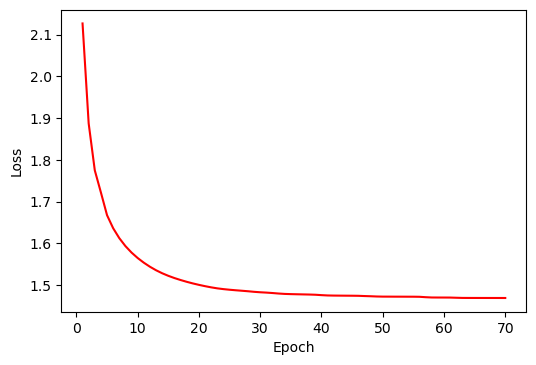

In [10]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(range(1, nepochs+1), loss_values, color='red')
plt.savefig("Loss curve")
plt.show()

In [11]:
test()

Testing complete
Accuracy: 89.24302788844622%
total time = 6.049371004104614 sec
